In [1]:
import pandas as pd
import numpy as np
import time                     #python 自带
from astropy.time import Time   #astropy 
from astropy import units as u 
from astropy.coordinates import cartesian_to_spherical
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS
import ligo.skymap.plot

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from moviepy.video.io.bindings import mplfig_to_npimage#动图生成
import moviepy.editor as mpy


def randUnitVec(number):
    phi      = np.random.rand(number,1) * 2 * np.pi  #方位角
    costheta = np.random.rand(number,1) * 2 - 1
    x = np.sqrt(1 - costheta**2) * np.cos(phi)
    y = np.sqrt(1 - costheta**2) * np.sin(phi)
    z = costheta
    r = np.concatenate([x, y, z], axis = 1)
    return r #(x,y,z)

def vecCross(a, b):
    e = np.zeros((3, 3, 3))
    e[0, 1, 2] = e[1, 2, 0] = e[2, 0, 1] = 1
    e[0, 2, 1] = e[2, 1, 0] = e[1, 0, 2] = -1

    c = [np.einsum("i,j,ijk->k", a[i,:],b[i,:], e) for i in range(0, len(a))]
    return np.vstack(c) #(x,y,z)

def vecDot(a, b):
    c = [np.inner(a[i],b[i]) for i in range(0, len(a))]
    return np.vstack(c) #(x,y,z)


def cart2spher(r):
    ans   =  cartesian_to_spherical(r[:,0], r[:,1], r[:,2])
    theta = ((np.pi/2 * u.radian - ans[1][0]) ).to('deg').value
    phi   = ans[2][0].to('deg').value
    return theta, phi


def transMat(ex, ey, ez):
    c = [np.vstack([ex[i], ey[i], ez[i]]) for i in range(0, len(ex))]
    return c


def W2ThetaPhi(trans, NVec):
    wt      = np.vstack([(np.inner(trans[i], NVec)).T for i in range(0, len(trans))])
    ewt     = wt / np.linalg.norm(wt, axis=1, keepdims=True)
    rLatLon = cartesian_to_spherical(ewt[:,0], ewt[:,1], ewt[:,2])
    theta   = np.pi/ 2 - rLatLon[1].value  #theta
    phi     = rLatLon[2].value # phi
    thetaPhi= np.vstack([theta, phi]).T
    return thetaPhi

def LNZ2Psi(LVec, NVec, ezd):
    psi = [np.arctan((vecDot(LVec, np.array([ezd[i]]) ) - vecDot(LVec, NVec) * vecDot(np.array([ezd[i]]), NVec)) \
                          / vecDot(NVec, vecCross(LVec, np.array([ezd[i]])))) for i in range(0, len(ezd))]
    return np.vstack(psi)


def Fplus1(theta, phi, psi):
    return 1/2 * (1 + (np.cos(theta))**2) * np.cos(2 * phi) * np.cos(2 * psi) \
- np.cos(theta)* np.sin(2 * phi) * np.sin(2 * psi) 

def Fcross1(theta, phi, psi):
    return 1/2 * (1 + (np.cos(theta))**2) * np.cos(2 * phi) * np.sin(2 * psi) \
+ np.cos(theta)* np.sin(2 * phi) * np.cos(2 * psi) 


def Fplus2(theta, phi, psi):
    return 1/2 * (1 + (np.cos(theta))**2) * np.sin(2 * phi) * np.cos(2 * psi) \
+ np.cos(theta)* np.cos(2 * phi) * np.sin(2 * psi) 

def Fcross2(theta, phi, psi):
    return 1/2 * (1 + (np.cos(theta))**2) * np.sin(2 * phi) * np.sin(2 * psi) \
- np.cos(theta)* np.cos(2 * phi) * np.cos(2 * psi) 


In [2]:
orbitDataTAIJI  =  pd.read_csv('orbitDataTAIJI.dat', index_col = 0)  #读取csv文件
orbitData      =  orbitDataTAIJI.loc[0:366,:]

sunPX = orbitData['sunPX']
sunPY = orbitData['sunPY']
sunPZ = orbitData['sunPZ']

earthPX = orbitData['earthPX']
earthPY = orbitData['earthPY']
earthPZ = orbitData['earthPZ']

scp1X = orbitData['scp1X']
scp1Y = orbitData['scp1Y']
scp1Z = orbitData['scp1Z']

scp2X = orbitData['scp2X']
scp2Y = orbitData['scp2Y']
scp2Z = orbitData['scp2Z']

scp3X = orbitData['scp3X']
scp3Y = orbitData['scp3Y']
scp3Z = orbitData['scp3Z']

scpX = (scp1X + scp2X + scp3X) / 3  
scpY = (scp1Y + scp2Y + scp3Y) / 3  
scpZ = (scp1Z + scp2Z + scp3Z) / 3  

scp = (np.vstack([scpX, scpY, scpZ])).T
scp1 = (np.vstack([scp1X, scp1Y, scp1Z])).T
scp2 = (np.vstack([scp2X, scp2Y, scp2Z])).T
scp3 = (np.vstack([scp3X, scp3Y, scp3Z])).T


d12 = scp2 - scp1 
d13 = scp3 - scp1
xd  = d12 + d13

ed12 = d12 / np.linalg.norm(d12, axis=1, keepdims=True)
ed13 = d13 / np.linalg.norm(d13, axis=1, keepdims=True)


exd = xd / np.linalg.norm(xd, axis=1, keepdims=True)
ezd = vecCross(ed13, ed12)
eyd = vecCross(ezd, exd)


trans = transMat(exd, eyd, ezd)

NVec = np.array([[-0.21754308, -0.88794532, -0.40525068]]) #randUnitVec(1)
LVec = NVec + np.array([[1e-13,1e-13,1e-13]])#randUnitVec(1)

LVec = LVec / np.linalg.norm(LVec, axis=1, keepdims=True)

print(NVec, LVec)

# vecDot(ezd,eyd)
# vecDot(exd,eyd)
# vecDot(ezd,exd)

[[-0.21754308 -0.88794532 -0.40525068]] [[-0.21754308 -0.88794532 -0.40525068]]


In [3]:
thetaPhi = W2ThetaPhi(trans, NVec)
theta = thetaPhi[:,0]
phi = thetaPhi[:,1]
psi = LNZ2Psi(LVec, NVec, ezd)[:,0]

####
Fp1 = Fplus1(theta, phi, psi)
Fc1 =  Fcross1(theta, phi, psi)
Fp2 = Fplus2(theta, phi, psi)
Fc2 =  Fcross2(theta, phi, psi)

In [4]:
ans = np.vstack([Fp1, Fc1, Fp2, Fc2]).T
ans

array([[-0.55213153, -0.15030405, -0.20878742,  0.39747606],
       [-0.55908108, -0.15004876, -0.20457612,  0.41006605],
       [-0.56604048, -0.1496424 , -0.20044485,  0.42257942],
       ...,
       [-0.53379305, -0.15010479, -0.2202415 ,  0.36380784],
       [-0.54065832, -0.15038544, -0.21594793,  0.37651528],
       [-0.54754244, -0.15047867, -0.21171637,  0.38917117]])

In [5]:
timeVec = orbitData['timeJD']

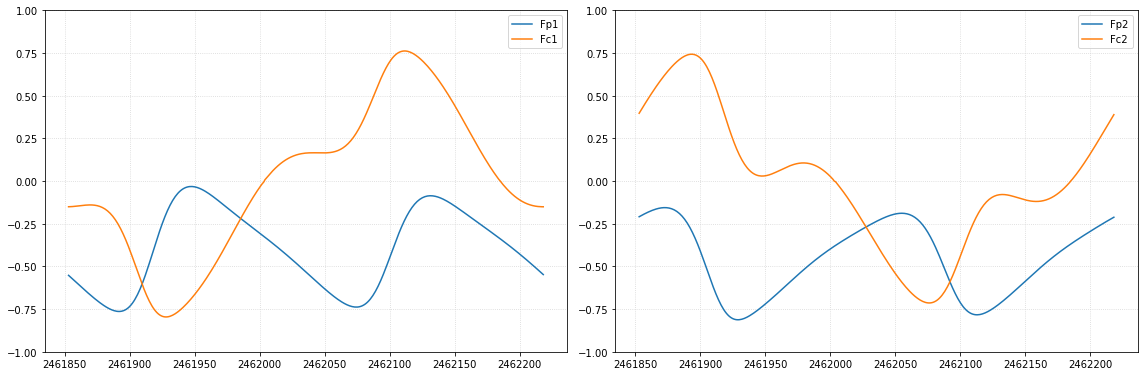

In [6]:
plt.figure(figsize=(16,8/1.5))
plt.subplot(121)
plt.plot(timeVec, Fp1, label='Fp1')
plt.plot(timeVec, Fc1, label='Fc1')
plt.ylim(-1, 1)
plt.legend(loc='upper right')
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")

plt.subplot(122)
plt.plot(timeVec, Fp2, label='Fp2')
plt.plot(timeVec, Fc2, label='Fc2')
plt.ylim(-1, 1)
plt.legend(loc='upper right')
plt.tight_layout()
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")

plt.show()

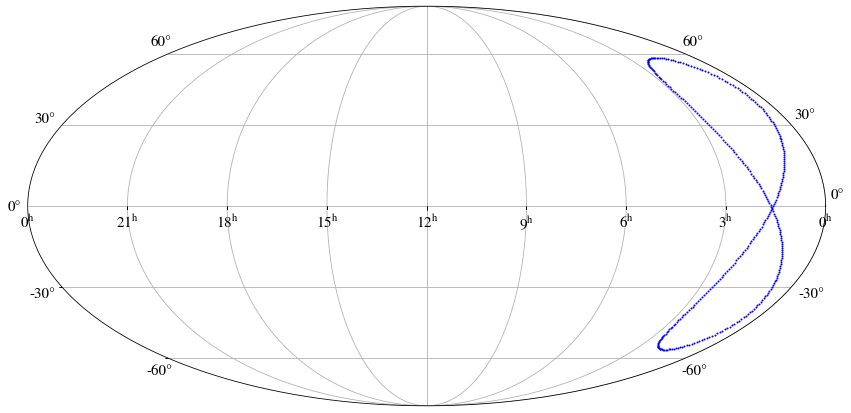

In [7]:
source= SkyCoord(phi , np.pi/2 - theta, unit="radian", frame = 'icrs')  # defaults to ICRS frame

matplotlib.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
# 绘图


fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection='astro hours mollweide')

ax.plot_coord(source,'o',c='blue',markersize=1)

ax.grid(ax)
plt.tight_layout()
plt.show()

t:   1%|          | 2/300 [00:00<00:28, 10.49it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


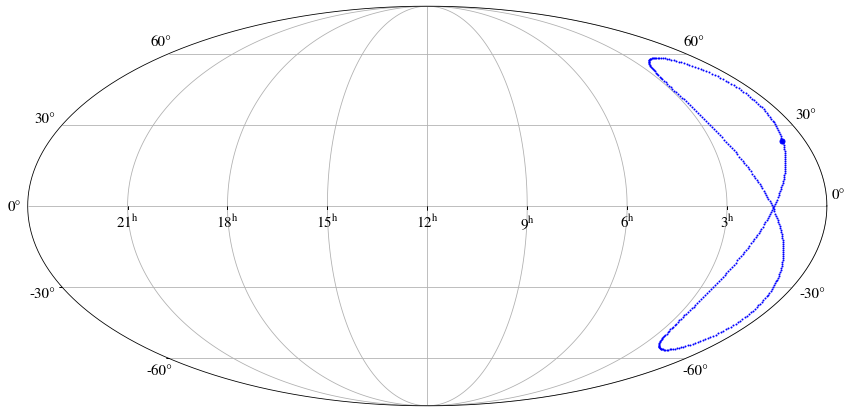

In [8]:
# #绘动图3d2#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
matplotlib.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
# 绘图

duration = 10 #总共的时间       figsize代表横纵比
speed = 1.0#播放速率    
number = len(source)

# plt.style.use('dark_background')


fig_mpl = plt.figure(figsize=(12,6))

# 使用MOVIEPY让图动起来(根据时间t来更新图). 保存为GIF.
def make_frame_mpl(t):
    tNorm = t/duration      #0 --> 1
    index = int(number*(t/duration))  #0 --> number
  
    ax = fig_mpl.add_subplot(111, projection='astro hours mollweide')
    ax.remove() #ax.clear不管用,会将整个ax框架清除，而不是只把图像清除
    ax = fig_mpl.add_subplot(111, projection='astro hours mollweide')

    #source
    ax.plot_coord(source[index],'o',c='blue',markersize=5)
    ax.plot_coord(source[0:(index + 1)],'o', c='blue', markersize=1)
 

    ax.grid(ax)
    plt.tight_layout()
    return mplfig_to_npimage(fig_mpl) # RGB image of the figure

animation =mpy.VideoClip(make_frame_mpl, duration=duration)
# animation.speedx(speed).write_videofile("taiji_orbit.mp4", fps=30) #输出mp4, speedx表示播放速度(1.0为正常速度), fps每秒帧数
#animation.speedx(speed).write_gif("TAIJI&LISA.gif", fps=30) #输出mp4, speedx表示播放速度(1.0为正常速度), fps每秒帧数
animation.speedx(speed).ipython_display(fps=30, loop=1, autoplay=0)

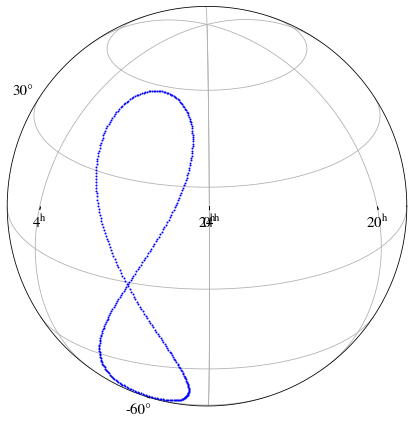

In [9]:
source= SkyCoord(phi , np.pi/2 - theta, unit="radian", frame = 'icrs')  # defaults to ICRS frame

matplotlib.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
# 绘图

theta_mean = np.pi/2 - np.mean(theta)
phi_mean = np.mean(phi) 
C_center = SkyCoord(theta_mean , phi_mean, unit="radian", frame = 'icrs')  # defaults to ICRS frame

fig = plt.figure(figsize=(12,6))
# ax = plt.axes(projection='astro hours mollweide')
ax = plt.axes(projection='astro globe', center= C_center)
ax.plot_coord(source,'o',c='blue',markersize=1)

ax.grid(ax)
plt.tight_layout()
plt.show()

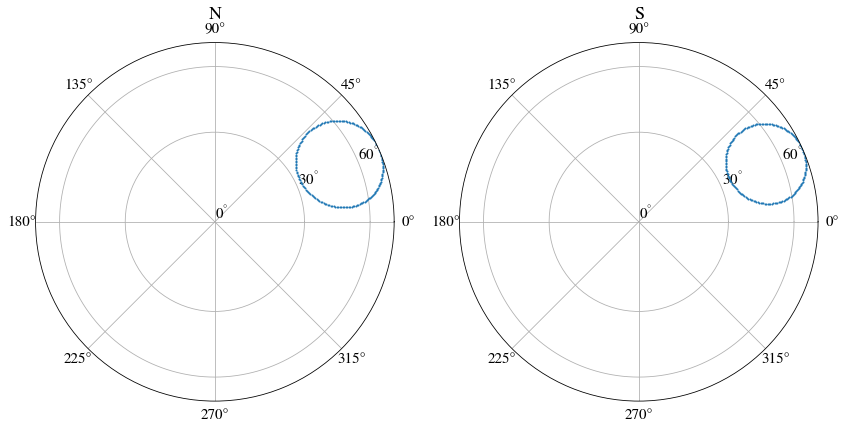

In [10]:
matplotlib.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
# 绘图


fig = plt.figure(figsize=(12,6))

ax1 = plt.subplot(121, projection='polar')
ax1.plot(phi[theta <= np.pi/2], np.sin(theta[theta <= np.pi/2]), 'o', markersize=1)
ax1.set_rgrids(np.sin([0, np.pi/6, np.pi/3]), labels = ['$0^{\degree}$', '$30^{\degree}$', '$60^{\degree}$'])
ax1.set_rlim(0,1)
ax1.set_title('N')


ax2 = plt.subplot(122, projection='polar')

ax2.set_rlim(0,1)
ax2.plot(phi[theta >= np.pi/2], np.sin(theta[theta >= np.pi/2]), 'o', markersize=1)
ax2.set_rgrids(np.sin([0, np.pi/6, np.pi/3]), labels = ['$0^{\degree}$', '$30^{\degree}$', '$60^{\degree}$'])
ax2.set_title('S')
# ax.plot_coord(source,'o',c='blue',markersize=1)

# ax.grid(ax)
plt.tight_layout()
plt.show()